Principal component/correlation
  Component  Eigenvalue  Std. Err.     z  P > |z|  Proportion  Cumulative
0     Comp1    2.875535   0.909324  3.16    0.002    0.575107    0.575107
1     Comp2    1.194020   0.377582  3.16    0.002    0.238804    0.813911
2     Comp3    0.416236   0.131625  3.16    0.002    0.083247    0.897158
3     Comp4    0.290079   0.091731  3.16    0.002    0.058016    0.955174
4     Comp5    0.224130   0.070876  3.16    0.002    0.044826    1.000000


Principal component (all eigenvectors)
   Variables    Comp 1    Comp 2    Comp 3    Comp 4    Comp 5
0   Japanese  0.464411 -0.406153  0.261232  0.684713 -0.286860
1       Math  0.364799  0.630381 -0.364070  0.429168  0.390908
2    English  0.511046 -0.081152 -0.594234 -0.373219 -0.489735
3    Science  0.410842  0.494651  0.661502 -0.324890 -0.208306
4  Sociology  0.470410 -0.431734  0.092263 -0.319590  0.694025


Principal component (eigenvalue > 1)
Component1
   Variables  Eigenvectors  Std. Err.     z  P > |z|  F

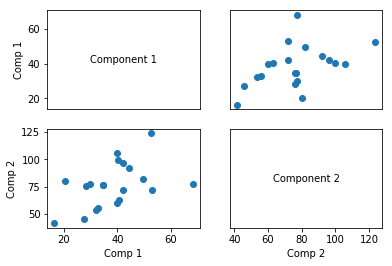

In [16]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import numpy.linalg as LA
import math
import sys
from scipy.stats import chi2, norm
from matplotlib import pyplot

"""
** Parameters dependent on users **
    - data: targeted data
    - variable: the ones you want to summarize through principal component analysis (NumPy)

n: number of records
p: number of parameters (variables you want to summarize or reduce the dimensions)
designMatrix: designMatrix (= data[variable].values)

eigenvalue=1
cummulative=0.8
cov=0
"""
def verify_eigenvectors(eigenvectors):
    p = eigenvectors.shape[1]
    verify_eigenvectors = np.empty((0,p))
    for i in range(p):
        eigenvectors_T_i = np.zeros(p)
        if np.ones(p).dot(eigenvectors.T[i]) < 0:
            verify_eigenvectors_T_i = -1 * eigenvectors.T[i]
        else:
            verify_eigenvectors_T_i = eigenvectors.T[i]
        verify_eigenvectors = np.append(verify_eigenvectors, np.array([verify_eigenvectors_T_i]), axis=0)
        
    return verify_eigenvectors.T

def eigen(matrix):
    eigenvalues, eigenvectors = LA.eig(matrix)
    eigenvectors = verify_eigenvectors(eigenvectors)
    
    eigen_id = np.argsort(eigenvalues)[::-1]
        
    eigenvalues = eigenvalues[eigen_id]
    eigenvectors = eigenvectors.T[eigen_id].T
        
    return eigenvalues, eigenvectors

"""
・主成分分析に用いる計画行列の固有ベクトル及び固有値の標準誤差を求める関数
    C: NumPy配列の共分散行列か相関行列
"""

def vce(C):
    eigenvalues, eigenvectors = eigen(C)
    p = C.shape[1]    # number of parameters
    n = C.shape[0]    # number of data
        
    vceVectorMatrix = np.empty((0,p))
    vceValueVector = np.array([])
    for i in range(p):
        v_i = np.zeros(p)
        for j in range(p):
            if j != i:
                u_ij = eigenvalues[i] * eigenvalues[j] / ((eigenvalues[i] - eigenvalues[j]) ** 2) / (n - 1)
                v_ij = np.square(list(eigenvectors[k][j] for k in range(p)))
                v_i += u_ij * v_ij
                
        r_i = 2 * eigenvalues[i] ** 2 / (n - 1)

        vceValueVector = np.append(vceValueVector, np.array([r_i]))
        vceVectorMatrix = np.append(vceVectorMatrix, np.array([v_i]), axis=0)
    
    stdErr_eigenvectors = np.sqrt(vceVectorMatrix.T / n)
    stdErr_eigenvalues = np.sqrt(vceValueVector / n)
    return stdErr_eigenvectors, stdErr_eigenvalues
"""
・主成分分析の結果を表示する関数
    target: 主成分分析対象の変数セット(List型)
    eigenvalue: 主成分を抽出するための固有値閾値(通常は1以上よりeigenvalue=1)
    cummulative: 累積寄与率を基準にして固有値を抽出(通常は80%以上より、cummulative=0.8)
    cov: 共分散行列を用いて主成分分析を実施する際はcov=1とする。
"""
def pca(target=[], mineigen=0, cummulative=1, cov=0):
    
    Variables = {'Variables': target}
    FactorLoading1 = DataFrame(Variables)
    FactorLoading2 = DataFrame(Variables)
    Eigenvectors = DataFrame(Variables)
    
    X = data[target].values   # Design matrix
    V = np.cov(X, rowvar=False)    # Covariance matrix
    R = np.corrcoef(X, rowvar=False)   # Correlation matrix
    p = X.shape[1]    # number of parameters
    n = X.shape[0]    # number of records
    
    ComponentResult = {'Component': ['Comp' + str(i + 1) for i in range(p)]}
    Component = DataFrame(ComponentResult)
    
    if cov == 0:

        eig_vals, eig_vecs = eigen(R)
        all_eig_vals = sum(eig_vals)
        
        SE, se = vce(R)
        
        print('Principal component/correlation')
        
        Component['Eigenvalue'] = np.array([eig_vals[i] for i in range(p)])
        Component['Std. Err.'] = np.array([se[i] for i in range(p)])
        Component['z'] = np.array([round(eig_vals[i] / se[i], 2) for i in range(p)])
        Component['P > |z|'] = np.array([round(norm.sf(abs(eig_vals[i] / se[i]))*2, 3) 
                                   for i in range(p)])
        Component['Proportion'] = np.array([eig_vals[i] / all_eig_vals for i in range(p)])
        
        cumulative_contribution = 0
        CumulativeList = []
        for i in range(p):
            cumulative_contribution += eig_vals[i] / all_eig_vals
            CumulativeList.append(cumulative_contribution)    
        Component['Cumulative'] = np.array(CumulativeList)
        
        print(Component)
        print('\n')
        
        print('Principal component (all eigenvectors)')
        
        for i in range(p):
            Eigenvectors['Comp ' + str(i + 1)] = list(eig_vecs[j][i] for j in range(p))
        
        print(Eigenvectors)
        print('\n')
        print('Principal component (eigenvalue > ' + str(eigenvalue) + ')')

        for i in range(p):

            if eig_vals[i] > mineigen:
                FactorLoading_i = DataFrame(Variables)
                FactorLoading_i['Eigenvectors'] = np.array([eig_vecs[j][i] for j in range(p)])
                FactorLoading_i['Std. Err.'] = np.array([SE[j][i] for j in range(p)])
                FactorLoading_i['z'] = np.array([round(eig_vecs[j][i] / SE[j][i], 2) for j in range(p)])
                FactorLoading_i['P > |z|'] = np.array([ round(norm.sf(abs(eig_vecs[j][i] / SE[j][i]))*2, 3)
                                                                              for j in range(p)])
                FactorLoading_i['Factor loadings'] = np.array([eig_vecs[j][i] * math.sqrt(eig_vals[i])
                                                                 for j in range(p)])
            else:
                break
            print('Component' + str(i + 1))
            print(FactorLoading_i)
            print('\n')
    
        print('Prinipal component (cumulative level: ' + str(cummulative) + ')')
        
        cumulative_contribution = 0
    
        for i in range(p):
                
            if cumulative_contribution < cummulative:
                FactorLoading_i = DataFrame(Variables)
                FactorLoading_i['Eigenvectors'] = np.array([eig_vecs[j][i] for j in range(p)])
                FactorLoading_i['Std. Err.'] = np.array([SE[j][i] for j in range(p)])
                FactorLoading_i['z'] = np.array([round(eig_vecs[j][i] / SE[j][i], 2) for j in range(p)])
                FactorLoading_i['P > |z|'] = np.array([round(norm.sf(abs(eig_vecs[j][i] / SE[j][i]))*2, 3)
                                                                              for j in range(p)])
                FactorLoading_i['Factor loadings'] = np.array([eig_vecs[j][i] * math.sqrt(eig_vals[i])
                                                                 for j in range(p)])
                cumulative_contribution += eig_vals[i] / all_eig_vals
            
            else:
                break
            
            print('Component' + str(i + 1))
            print(FactorLoading_i)
            print('\n')
        
        independence = - ( n - (2 * p + 5) / 6) * math.log(LA.det(R))
        df = p * (p-1) / 2
        print( 'LR test for independence: chi' + '('+ str(round(df)) + ') = ' + str(round(independence, 2)) 
              + '  Prob > chi2 = ' +str(round(chi2.sf(independence, df, loc=0, scale=1), 4)))
        
        D = np.diag(eig_vals)
        sphericity = - ( n - ( 2*p**2 + p + 2) / 6 /p) * (math.log(LA.det(D)) - p * math.log(np.trace(D)/p)) 
        df = (p+2)*(p-1)/2
        print( 'LR test for   sphericity: chi' + '('+ str(round(df)) + ') = ' + str(round(sphericity, 2)) 
              + '  Prob > chi2 = ' +str(round(chi2.sf(sphericity, df, loc=0, scale=1), 4)))
            
    elif cov == 1:
        
        eig_vals, eig_vecs = eigen(V)
        all_eig_vals = sum(eig_vals)
        
        SE, se = vce(V)
        
        print('Principal component/covariance')
        
        Component['Eigenvalue'] = np.array([eig_vals[i] for i in range(p)])
        Component['Std. Err.'] = np.array([se[i] for i in range(p)])
        Component['z'] = np.array([round(eig_vals[i] / se[i], 2) for i in range(p)])
        Component['P > |z|'] = np.array([round(norm.sf(abs(eig_vals[i] / se[i]))*2, 3) 
                                   for i in range(p)])
        Component['Proportion'] = np.array([eig_vals[i] / all_eig_vals for i in range(p)])
        
        cumulative_contribution = 0
        CumulativeList = []
        for i in range(p):
            cumulative_contribution += eig_vals[i] / all_eig_vals
            CumulativeList.append(cumulative_contribution)    
        Component['Cumulative'] = np.array(CumulativeList)
        
        print(Component)
        print('\n')
        
        print('Principal component (all eigenvectors)')
        
        for i in range(p):
            Eigenvectors['Comp ' + str(i + 1)] = list(eig_vecs[j][i] for j in range(p))
        
        print(Eigenvectors)
        print('\n')
        print('Principal component (eigenvalue > ' + str(eigenvalue) + ')')
        print('\n')

        for i in range(len(eig_vals)):
        
            if eig_vals[i] > mineigen:
                FactorLoading_i = DataFrame(Variables)
                FactorLoading_i['Eigenvectors'] = np.array([eig_vecs[j][i] for j in range(p)])
                FactorLoading_i['Std. Err.'] = np.array([SE[j][i] for j in range(p)])
                FactorLoading_i['z'] = np.array([round(eig_vecs[j][i] / SE[j][i], 2) for j in range(p)])
                FactorLoading_i['P > |z|'] = np.array([round(norm.sf(abs(eig_vecs[j][i] / SE[j][i]))*2, 3)
                                                                              for j in range(p)])
                FactorLoading_i['Factor loadings'] = np.array([eig_vecs[j][i] * math.sqrt(eig_vals[i] / V[j][j])
                                                                 for j in range(len(eig_vals))])
            
            else:
                break
            
            print('Component' + str(i + 1))
            print(FactorLoading_i)
            print('\n')
    
        print('Prinipal component (cumulative level: ' + str(cummulative) + ')')

        cumulative_contribution = 0
    
        for i in range(len(eig_vals)):
                
            if cumulative_contribution < cummulative:
                FactorLoading_i = DataFrame(Variables)
                FactorLoading_i['Eigenvectors'] = np.array([eig_vecs[j][i] for j in range(p)])
                FactorLoading_i['Std. Err.'] = np.array([SE[j][i] for j in range(p)])
                FactorLoading_i['z'] = np.array([round(eig_vecs[j][i] / SE[j][i], 2) for j in range(p)])
                FactorLoading_i['P > |z|'] = np.array([round(norm.sf(abs(eig_vecs[j][i] / SE[j][i]))*2, 3)
                                                                              for j in range(p)])
                FactorLoading_i['Factor loadings'] = np.array([eig_vecs[j][i] * math.sqrt(eig_vals[i] / V[j][j])
                                                                 for j in range(len(eig_vals))])
                cumulative_contribution += eig_vals[i] / all_eig_vals
            
            else:
                break
            
            print('Component' + str(i + 1))
            print(FactorLoading_i)
            print('\n')
        
        independence = - ( n - (2 * p + 5) / 6) * math.log(LA.det(R))
        df = p * (p-1) / 2
        print( 'LR test for independence: chi' + '('+ str(round(df)) + ') = ' + str(round(independence, 2)) 
              + '  Prob > chi2 = ' +str(round(chi2.sf(independence, df, loc=0, scale=1), 4)))
        
        D = np.diag(eig_vals)
        sphericity = - ( n - ( 2*p**2 + p + 2) / 6 /p) * (math.log(LA.det(D)) - p * math.log(np.trace(D)/p)) 
        df = (p+2)*(p-1)/2
        print( 'LR test for   sphericity: chi' + '('+ str(round(df)) + ') = ' + str(round(sphericity, 2)) 
              + '  Prob > chi2 = ' +str(round(chi2.sf(sphericity, df, loc=0, scale=1), 4)))
    
    else:
        print('Error')

"""
・主成分スコアを求める関数
    designMatrix: NumPy配列の主成分分析対象の計画行列
    NumberOfComponent: 指定した数値だけの主成分軸の主成分スコアを求める
    cummulative: 累積寄与率を基準にして固有値を抽出(通常は80%以上より、cummulative=0.8)
    Covariance: 共分散行列を用いて主成分スコアを求める際はCovariance=1とする。
"""
def score(designMatrix, numberOfComponent=2, covariance=0):
    if covariance == 1:
        C = np.cov(designMatrix, rowvar=False)
    else:
        C = np.corrcoef(designMatrix, rowvar=False)
        
    p = designMatrix.shape[1]
    n = designMatrix.shape[0]
    if numberOfComponent < 1 or numberOfComponent > p:
        print('Error!: number of components is incorrect.')
        scoreMatrix = None
        
    else:
        eig_vecs = LA.eig(C)[1]
        eig_vecs = verify_eigenvectors(eig_vecs)
        scoreMatrix = np.empty((0,n))
        for i in range(numberOfComponent):
            scoreMatrix_i = np.array([])
            for j in range(n):
                scoreMatrix_i = np.append(scoreMatrix_i, np.array([designMatrix[j].dot(eig_vecs[i])]))
            scoreMatrix = np.append(scoreMatrix, np.array([scoreMatrix_i]), axis = 0)
            data['Score for component ' + str(i + 1)] = scoreMatrix_i
            
    return scoreMatrix, numberOfComponent

def plotComponentScore(scoreMatrix, numberOfComponent):

    fig, ax = pyplot.subplots(numberOfComponent, numberOfComponent)

    for i in range(numberOfComponent):
        for j in range(numberOfComponent):

            # scatter column_j on the x-axis vs column_i on the y-axis
            if i != j: 
                ax[i][j].scatter(scoreMatrix[j], scoreMatrix[i])

            # unless i == j, in which case show the series name
            else: ax[i][j].annotate("Component " + str(i + 1), (0.5, 0.5),
                                    xycoords='axes fraction',
                                    ha="center", va="center")
            
            ax[i][j].set_xlabel('Comp ' + str(j + 1))
            ax[i][j].set_ylabel('Comp ' + str(i + 1))
            # then hide axis labels except left and bottom charts
            if i < numberOfComponent - 1: ax[i][j].xaxis.set_visible(False)
            if j > 0: ax[i][j].yaxis.set_visible(False)

    # fix the bottom right and top left axis labels, which are wrong because
    # their charts only have text in them
    ax[-1][-1].set_xlim(ax[0][-1].get_xlim())
    ax[0][0].set_ylim(ax[0][1].get_ylim())
    
    print('Plot of scores for principal components')
    pyplot.show()

if __name__ == '__main__':
    
    data = pd.read_csv("testdata2.csv")
    target = ['Japanese','Math','English','Science','Sociology']    
    X = data[target].values   # Design matrix
    eigenvalue=1
    cummulative=0.8
    cov=0

    #data.to_csv('testdata2.csv')
    pca(target,eigenvalue, cummulative, cov)
    print('\n')
    
    scoreMatrix, NumberOfComponent = score(X)
    plotComponentScore(scoreMatrix, NumberOfComponent)